###Setting up our Random Number Generator

In [21]:
%%writefile random_number_gen.pyx

import numpy as np
cimport numpy as np
import scipy

cimport scipy
from cpython.mem cimport PyMem_Malloc, PyMem_Free
cdef class RandomNumberGen:
    cdef unsigned long long mod1, a1, a2, a3, mod2, b1, b2, b3, x0, x1, x2
    cdef double multiplicator
    cdef bint LHS

    def __cinit__(self):
        self.mod1 = 2**31 - 1
        self.a1 = 0
        self.a2 = 63308
        self.a3 = -183326
        self.mod2 = 2145483479
        self.b1 = 86098
        self.b2 = 0
        self.b3 = -539608
        self.x0=17  ## Define Seed Here
        self.x1=37  ## Define Seed Here
        self.x2=13337 ## Define Seed Here
        self.multiplicator=4.656612875245797e-10
        self.LHS=True

    cpdef double Scrambled_Random(self):
        cdef unsigned long long Component1, Component2, Combined, y
        Component1 = (self.x2 * self.a1 + self.x1 * self.a2 + self.x0 * self.a3) % self.mod1
        Component2 = (self.x2 * self.b1 + self.x1 * self.b2 + self.x0 * self.b3) % self.mod2
        Combined = (Component1 - Component2) % self.mod1
        if Combined < 0:
            Combined += self.mod1
        y = Combined
        y ^= (y << 17)  # Parentheses to avoid type mismatch
        y ^= (y >> 15)  # Parentheses to avoid type mismatch
        y ^= (y << 26)  # Parentheses to avoid type mismatch
        y = y % self.mod1
        self.x2, self.x1, self.x0 = y, self.x2, self.x1

        return y*self.multiplicator

    cpdef np.ndarray generate_matrix(self, int rows,int cols,LHS=True):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((rows, cols), dtype=np.double)
        cdef Py_ssize_t i, j
        if LHS:
            for i in range(rows):
                for j in range(cols):
                    matrix[i, j] = i/rows+self.Scrambled_Random()/rows
            for j in range(cols):
                matrix[:, j] = np.random.permutation(matrix[:, j])
            return matrix
        else:
            for i in range(rows):
                for j in range(cols):
                    matrix[i, j] = self.Scrambled_Random()
            return matrix
        




        return matrix
    cpdef np.ndarray inverse_transform(self, np.ndarray input_matrix,np.ndarray CDF_matrix,np.ndarray X_vector):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((input_matrix.shape[0], input_matrix.shape[1]), dtype=np.double)
        cdef Py_ssize_t i, j
        cdef double u
        for i in range(input_matrix.shape[0]):
            for j in range(input_matrix.shape[1]):
                u = input_matrix[i, j]
                matrix[i, j] = np.interp(u, CDF_matrix, X_vector)

        return matrix
    cpdef np.ndarray generate_poisson(self,int rows,int cols,double lambda_,bint Antithetic=True):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((rows, cols), dtype=np.double)
        cdef Py_ssize_t  i, j
        cdef double comp=np.exp(-lambda_)
        cdef np.ndarray[np.double_t,ndim=2] Sample
        cdef double u,u2,k1,k2,comp2,Prob
        if Antithetic:
            sample=self.generate_matrix(rows//2,cols)
            for i in range(rows//2):
                for j in range(cols):
                    comp2=comp
                    Prob=comp
                    u=sample[i,j]
                    u2=1-u
                    k1=0
                    k2=0
                    
                    while u>comp2:
                        k1=k1+1
                        Prob=lambda_/k1*Prob
                        comp2=comp2+Prob
                    comp2=comp
                    Prob=comp
                    while u2>comp2:  
                        
                        k2=k2+1
                        Prob=lambda_/k2*Prob
                        comp2=comp2+Prob
                    matrix[int(2*i),j]=k1
                    matrix[int(2*i+1),j]=k2

        else:
            sample=self.generate_matrix(rows,cols)
            for i in range(rows):
                for j in range(cols):
                    comp2=comp
                    Prob=comp
                    u=sample[i,j]
                    k1=0
                    while u>comp2:
                        k1+=1
                        Prob=lambda_/k1*Prob
                        comp2=comp2+Prob
                    matrix[i,j]=k1
        return matrix
    cpdef np.ndarray generate_normal(self,int rows, int cols,double loc=0,double scale=1,Antithetic=True):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((rows, cols), dtype=np.double)
        cdef int x
        if Antithetic:
            x=rows//2
        else:
            x=rows

        matrix=scipy.stats.norm.ppf(self.generate_matrix(x,cols))

        if Antithetic:
            matrix=np.concatenate([matrix,-matrix])
        matrix=loc*np.ones((rows,cols))+scale*matrix
        return matrix


    cpdef np.ndarray generate_double_exponential(self,int rows, int cols,double p, double eta1,double eta2,Antithetic=True):
        cdef double q=1-p
        cdef np.ndarray U,negU,PosSamp,NegSamp,AntPosSamp,AntNegSamp,Ou1,Out2
        if Antithetic:
            U=self.generate_matrix(rows//2,cols)
            PosSamp=(1/eta2)*np.log((1/q)*U)
            NegSamp=-(1/eta1)*np.log((1/p)*(np.ones((rows//2,cols))-U))
            Out1=np.where(U<p*np.ones((rows//2,cols)),PosSamp,NegSamp)
            negU=np.ones((rows//2,cols))-U
            AntPosSamp=(1/eta2)*np.log((1/q)*negU)
            AntNegSamp=(1/eta1)*np.log((1/p)*(np.ones((rows//2,cols))-negU))
            Out2=np.where(negU<p*np.ones((rows//2,cols)),AntPosSamp,AntNegSamp)
            return np.concatenate([Out1,Out2])
        else:
            U=self.generate_matrix(rows,cols)
            PosSamp=(1/eta2)*np.log((1/q)*U)
            NegSamp=-(1/eta1)*np.log((1/p)*(np.ones((rows,cols))-U))
            Out1=np.where(U<p*np.ones((rows,cols)),PosSamp,NegSamp)
            return Out1
    cpdef np.ndarray generate_CGMY_Ylessthan1(self,int rows,int cols,double C,double G,double M,double Y):
        cdef np.ndarray[np.double_t, ndim=2] matrix = self.generate_matrix(rows,cols)
        
        p=G**Y/(G**Y+M**Y)
        q=1-p
        matrix=np.where(matrix<p,-scipy.special.gammainccinv(-Y,matrix/p)/G,scipy.special.gammaincinv(-Y,(matrix-p)/q)/M) ## we only have the inverse of regularized so we divide by gamma(-y) in the incomplete gamma functions
        return matrix


Overwriting random_number_gen.pyx


In [22]:
!cython --cplus random_number_gen.pyx

C:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\Cython\Compiler\Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: c:\Users\Bram\JumpDiffusionModel\random_number_gen.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [23]:
%%writefile setup.py
from setuptools import setup
from Cython.Build import cythonize
import numpy
import scipy
setup(
    ext_modules=cythonize("random_number_gen.pyx"),
    include_dirs=[numpy.get_include(),scipy.get_include()]
)

Overwriting setup.py


In [24]:
!python setup.py build_ext --inplace

Compiling random_number_gen.pyx because it changed.
[1/1] Cythonizing random_number_gen.pyx
running build_ext
building 'random_number_gen' extension
"C:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.39.33519\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD -Ic:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\include -Ic:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\include -Ic:\Users\Bram\AppData\Local\Programs\Python\Python312\include -Ic:\Users\Bram\AppData\Local\Programs\Python\Python312\Include "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.39.33519\include" "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.39.33519\ATLMFC\include" "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Auxiliary\VS\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.22621.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\\inc

c:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\Cython\Compiler\Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: c:\Users\Bram\JumpDiffusionModel\random_number_gen.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
c:\Users\Bram\JumpDiffusionModel\setup.py:7: DeprecationWarning: scipy.get_include is deprecated and will be removed in SciPy 2.0.0, use numpy.get_include instead
  include_dirs=[numpy.get_include(),scipy.get_include()]
error: could not delete 'random_number_gen.cp312-win_amd64.pyd': Accès refusé


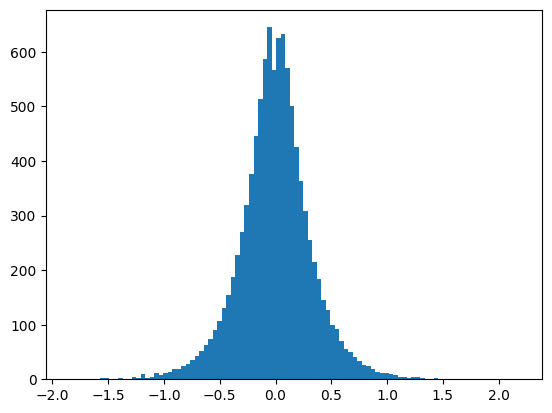

In [25]:
import numpy as np
import random_number_gen
import scipy
import matplotlib.pyplot as plt
gen=random_number_gen.RandomNumberGen()
X=gen.generate_CGMY_Ylessthan1(1000,10,3,5,5,-1.2)
plt.hist(X.flatten(),bins=100)
plt.show()


###Comparing RNGs

In [26]:
class RandomNumberGen():
    def __init__(self,seed):
        self.mod1=2**31-1
        self.a1=0
        self.a2=63308
        self.a3=-183326
        self.mod2=2145483479
        self.b1=86098
        self.b2=0
        self.b3=-539608
        self.x0,self.x1,self.x2=seed


    def Scrambled_Random(self):
        Component1=(self.x2*self.a1+self.x1*self.a2+self.x0*self.a3)%self.mod1
        Component2=(self.x2*self.b1+self.x1*self.b2+self.x0*self.a3)%self.mod2
        Combined=(Component1-Component2)%self.mod1 ##mod1>mod2
        if Combined<0:
            Combined+=self.mod1
        y=Combined
        y^=y<<17


        y^=y>>15


        y^=y<<26

        y=y%self.mod1

        self.x2,self.x1,self.x0=y,self.x2,self.x1

        return y/self.mod1
    def Random(self):
        Component1=(self.x2*self.a1+self.x1*self.a2+self.x0*self.a3)%self.mod1
        Component2=(self.x2*self.b1+self.x1*self.b2+self.x0*self.a3)%self.mod2
        Combined=(Component1-Component2)%self.mod1 ##mod1>mod2
        if Combined<0:
            Combined+=self.mod1
        self.x2,self.x1,self.x0=Combined,self.x2,self.x1
        return Combined/self.mod1
    def LCG(self):
        new=(self.x2*self.a2)%self.mod1
        self.x2=new
        new=new/self.mod1
        return new


In [27]:
import time
import numpy as np
import random_number_gen
RNG2=random_number_gen.RandomNumberGen()
RNG=RandomNumberGen((14,17,27))
start=time.time()
X=np.random.rand(1_000_000)
end=time.time()
print("time taken:",end-start)
start=time.time()
X=[RNG.Scrambled_Random() for _ in range(1_000_000)]
end=time.time()

print("time taken:",end-start)
start=time.time()
X=RNG2.generate_matrix(1_000_000,1)
end=time.time()
print("time taken:",end-start)

time taken: 0.007921934127807617


TypeError: 'numpy.ndarray' object is not callable

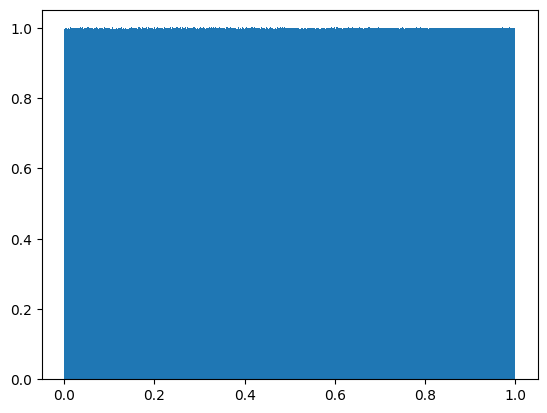

In [ ]:
import matplotlib.pyplot as plt
plt.hist(X,bins=2000,density=True)
         
plt.show()


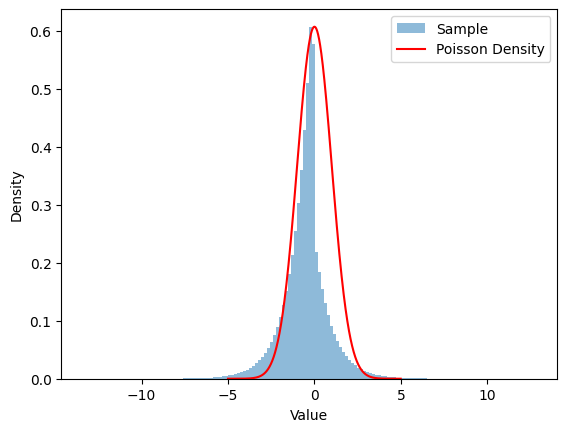

In [ ]:
import random_number_gen
gen=random_number_gen.RandomNumberGen()
import numpy as np
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
m=6
sample=gen.generate_double_exponential(1_000_000,1,0.5,1,1)
import matplotlib.pyplot as plt

value,hist,_=plt.hist(sample, bins=150, density=True, alpha=0.5, label='Sample')
x = np.arange(-5, 5,0.01)
pmf = norm.pdf(x)

plt.plot(x, pmf*max(value)/max(pmf), 'r-', label='Poisson Density')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()




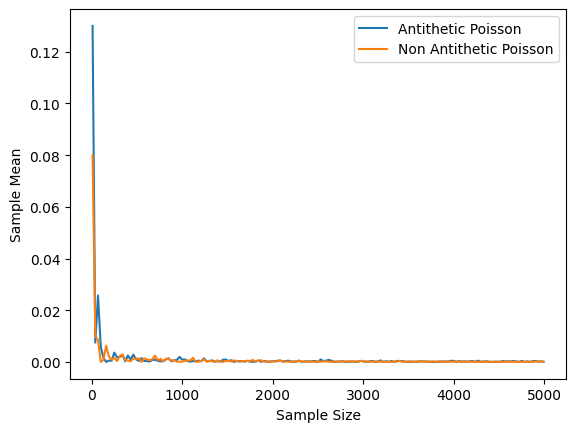

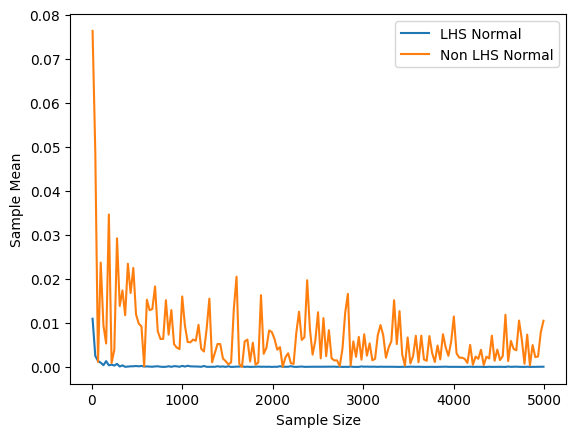

The slowest run took 26.44 times longer than the fastest. This could mean that an intermediate result is being cached.
2.05 s ± 2.43 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 36.63 times longer than the fastest. This could mean that an intermediate result is being cached.
1.41 s ± 1.6 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
import numpy as np
from scipy.stats import poisson
import numpy as np
from random_number_gen import RandomNumberGen
from scipy.stats import norm
import matplotlib.pyplot as plt
# Create an instance of RandomNumberGen
rng = RandomNumberGen()
range=np.arange(10,5000,30)
# Generate two arrays of Poisson random numbers
A1=[]
A2=[]
for i in range:
    poisson1 = rng.generate_poisson(i, 10,5,Antithetic=True) ###Both methods contain LHS so it is not surprising that they are similar in performance
    poisson2 = rng.generate_poisson(i, 10,5,Antithetic=False)
    A1.append(np.abs(np.mean(poisson1)-5))
    A2.append(np.abs(np.mean(poisson2)-5))
plt.plot(range,A1,label='Antithetic Poisson')
plt.plot(range,A2,label='Non Antithetic Poisson')
plt.xlabel('Sample Size')
plt.ylabel('Sample Mean')
plt.legend()
plt.show()
B1=[]
B2=[]

for i in range:
    normal1_sample=rng.generate_matrix(i,10,LHS=True)
    normal2_sample=rng.generate_matrix(i,10,LHS=False)
    normal1=norm.ppf(normal1_sample)
    normal2=norm.ppf(normal2_sample)
    B1.append(np.abs(np.mean(normal1)))
    B2.append(np.abs(np.mean(normal2)))
plt.plot(range,B1,label='LHS Normal')
plt.plot(range,B2,label='Non LHS Normal')
plt.xlabel('Sample Size')
plt.ylabel('Sample Mean')
plt.legend()
plt.show()
%timeit rng.generate_matrix(1_000_000,1,LHS=True)
%timeit rng.generate_matrix(1_000_000,1,LHS=False)
# Example usage



###CGMY Characteristic function inversion

Fourier Inversion Parameters:###########
alpha: 1.5060105705854605
D: 62.63946549765031
L_opt: 24.0
h: 0.04540252987314952
N: 529.0
eta: 0.11841108789725957


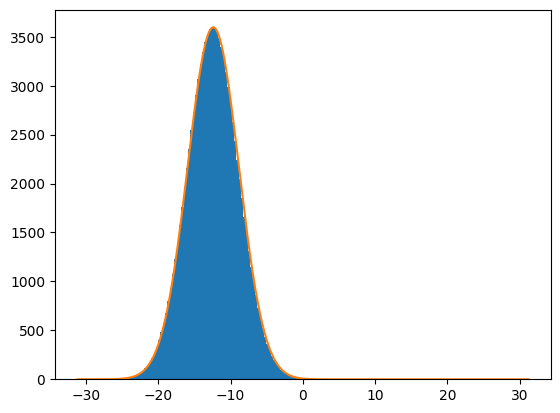

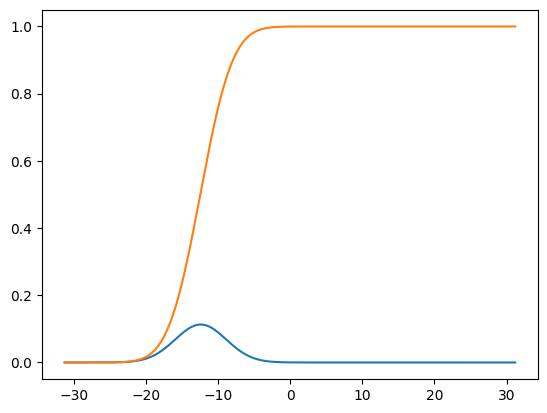

In [ ]:

from scipy.special import gamma,gammaincc
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import scipy
import random_number_gen
  # Rest of the code...
class CGMY():
  def __init__(self, C, G, M, Y, t, error):
    self.C = C
    self.G = G
    self.M = M
    if Y == int(Y):
      self.Y = Y - 0.03  ##to avoid overflow during gamma function evaluation
    else:
      self.Y = Y
    self.t = t
    self.error = error

  def characteristic_function(self,u,t,increment=[0,0,0,0]):

      C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
      return np.exp(t*C*gamma(-Y)*((M-1j*u)**Y-M**Y+(G+1j*u)**Y-G**Y))

  def calculate_K(self,increment=[0,0,0,0]):
    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
    
    return -C*gamma(-Y)*(M**Y+G**Y)

  def reg_characteristic_function(self,u,t):
    if u!=0:
      return -(1-np.cos(u*self.D))/(1j*u)*self.characteristic_function(u,t)
    else:
      return 0

  def L_error(self,L,B,b,beta,D,error):

    Bounderror=D*B/(np.pi*beta*b**(1/beta))*gammaincc(1/beta,b*(L/2)**beta)-error

    return L if Bounderror<0 else np.inf ##if bound is met, return L. Else, return infinity for penalty
  def alpha_minimization(self, alpha):
    t, error = self.t, self.error
    return np.real((2 / alpha) * np.log(
      (self.characteristic_function(1j * alpha, t) + self.characteristic_function(-1j * alpha, t)) / (2 * error / 3)))
  def L_value(self,b):
    res=optimize.minimize_scalar(self.L_error,args=(self.B,b,self.beta,self.D,self.error),bracket=[0, 1000], method='bounded',bounds=(0,35))
    return res.x
  def calculate_zeta(self, alpha):
    C, G, M, Y = self.C, self.G, self.M, self.Y
    term1 = -self.t * C * gamma(-Y) * (G ** Y - (G - alpha) ** Y)
    term2 = -self.t * C * gamma(-Y) * (M ** Y - (M + alpha) ** Y)
    term1 = np.clip(term1, a_min=None, a_max=600)#for numerical stability
    term2 = np.clip(term2, a_min=None, a_max=600)#for numerical stability
    return np.exp(np.logaddexp(term1, term2))

  def calculate_h_from_C(self, C):
    X = self.error * 2 * np.pi / (3 * C)
    return -2 * np.pi * self.alpha / (np.log(X / (1 + X)))
  def calculate_f(self,u,increment=[0,0,0,0]):
    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
    part1=(G**2/u**2+1)**(Y/2)*np.cos(Y*np.arctan(u/G))
    part2=(M**2/u**2+1)**(Y/2)*np.cos(Y*np.arctan(u/M))
    return gamma(-Y)*(part1+part2)
  def abs_char(self,u,alpha):
    return np.exp(self.t*self.K+self.t*self.C*np.abs(u)**self.Y*self.calculate_f(u,[0,-alpha,alpha,0]))


  def calculate_bound_A_integrals(self, alpha, u_star):
    """
    Calculates the bound A integrals for a given alpha and u_star.

    Parameters:
    alpha (float): The alpha value.
    u_star (float): The u_star value.

    Returns:
    float: The calculated bound A value.
    """
    stand_incr = [0, -alpha, alpha, 0]
    ##for calculating positive alpha integrals and zeta
    pos_alpha_K = self.calculate_K(increment=stand_incr)

    pos_alpha_int = scipy.integrate.quad(lambda x: self.abs_char(x,alpha),10e-10,u_star)[0]

    pos_alpha_upp = np.exp(self.t * pos_alpha_K) / (self.beta * self.b ** (1 / self.beta)) * gammaincc(1 / self.beta,
                self.b * u_star ** self.beta)
    
    pos_alpha_all_int = self.calculate_zeta(alpha) * (pos_alpha_int + pos_alpha_upp)
    ##for calculating negative alpha integrals and zeta
    neg_incr = [0, alpha, -alpha, 0]
    
    neg_alpha_K = self.calculate_K(increment=neg_incr)

    neg_alpha_int = scipy.integrate.quad(lambda x: self.abs_char(x,-alpha),10e-10,u_star)[0]
    
    neg_alpha_upp = np.exp(self.t * neg_alpha_K) / (self.beta * self.b ** (1 / self.beta)) * gammaincc(1 / self.beta,
                   self.b * u_star ** self.beta)

    neg_alpha_all_int = self.calculate_zeta(-alpha) * (neg_alpha_int + neg_alpha_upp)

    
    all_int = pos_alpha_all_int + neg_alpha_all_int+10e-9 #for numerical stability

    #for numerical stability
    part1 = np.exp(np.clip(((-self.D * self.alpha / 2+2*(self.D * self.alpha))), a_min=None, a_max=600))

    part2 = 2 * np.exp(np.clip((-self.D * self.alpha / 2+ self.D * self.alpha), a_min=None, a_max=600))
    part3 = np.exp(-self.D * self.alpha / 2)
    
    A = 1 / self.alpha * (part1+part2+part3) + all_int
    return A 

  def generate_cdf(self):
    """
    Generate the cumulative distribution function (CDF) for the Jump Diffusion Model.

    Parameters:
    

    Returns:
    - x_range (numpy.ndarray): An array of x values.
    - M (numpy.ndarray): An array of real values representing the CDF.

    """
    t=self.t
    ##Regularization error
    alpha_bounds = (0, np.min([self.G, self.M]))
    optimization = optimize.minimize_scalar(self.alpha_minimization, 1, bounds=alpha_bounds)
    self.alpha = optimization.x
    print("Fourier Inversion Parameters:###########")
    print("alpha:", self.alpha)
    self.D = optimization.fun
    print("D:", self.D)
    ##Truncating error
    self.K = self.calculate_K()
    K=self.K
    self.beta = self.Y
    self.B = np.exp(t * K)

    if self.Y > 1:
      u_star = max(self.G, self.M) * max(np.tan(np.pi / (2 * self.Y)), -1 / np.tan(self.Y * np.pi / 2))

      self.b = -t * self.C * self.calculate_f(np.ceil(u_star))
      C = self.calculate_bound_A_integrals(self.alpha, u_star)

      h=self.calculate_h_from_C(C)
      L_opt = max(self.L_value(self.b), np.ceil(u_star))
     
    elif self.Y > 0:
      b = -t * 2 * self.C * gamma(-self.Y) * np.cos(np.pi * self.Y / 2)
      L_opt = self.L_value(b)
      A = (2 * np.exp(-self.D * self.alpha / 2) * (np.exp(self.D * self.alpha) + 1) ** 2 * self.B * gamma(
        1 / self.beta)) / (self.alpha * self.beta * b ** (1 / self.beta))

      h=self.calculate_h_from_C(A)
    print("L_opt:", L_opt)
    print("h:", h)

    N = np.ceil(L_opt / h)
    print("N:", N)
    eta = self.D / N
    print(  "eta:", eta)





    ###Vectorized Operations for faster computation
 
    u_domain = np.arange(-N/2*h, (N/2)*h, h)
    x_range = np.arange(-N/2*eta, (N/2)*eta, eta)

    const = 1/(2*np.pi) * h

    
    reg_char_func_vect = np.vectorize(lambda u: self.reg_characteristic_function(u, t))

    # Computing the characteristic values for each u in u_domain
    characteristic_values = reg_char_func_vect(u_domain)

    # Pre-compute the exponential part using broadcasting
    # np.outer effectively creates a matrix where each row corresponds to an element in u_domain and each column to an element in x_range
    exp_matrix = np.exp(-1j * np.outer(u_domain, x_range))

    # Element-wise multiplication of exp_matrix with characteristic_values (reshaped for broadcasting)
    vect = exp_matrix * characteristic_values[:, np.newaxis]

    # Compute results by integrating (summing) over the u_domain for each x_range index
    res = const * vect
    real_res = np.sum(res, axis=0)  # Summing along the 'u_domain' axis

    M2 = real_res  # M contains the real parts of the computed values for each x_range index
    
    M2+=np.ones(len(M2))*0.5
    
    return x_range,np.real(M2)

# Test the code
cgmy = CGMY(C=24 , G=10, M=12, Y=1.7, t=65/365, error=10e-7)

C=cgmy.generate_cdf()
sample_gen=random_number_gen.RandomNumberGen()
sample_gen.inverse_transform(sample_gen.generate_matrix(100000,1),C[1],C[0])
hist_values,bins,_=plt.hist(sample_gen.inverse_transform(sample_gen.generate_matrix(100000,1),C[1],C[0]),bins=100)
Dx=C[0][1]-C[0][0]
D=np.diff(C[1])/Dx

plt.plot(C[0][1:],D*max(hist_values)/max(D))
plt.show()

plt.plot(C[0][1:],D)
plt.plot(C[0],C[1])

plt.show()

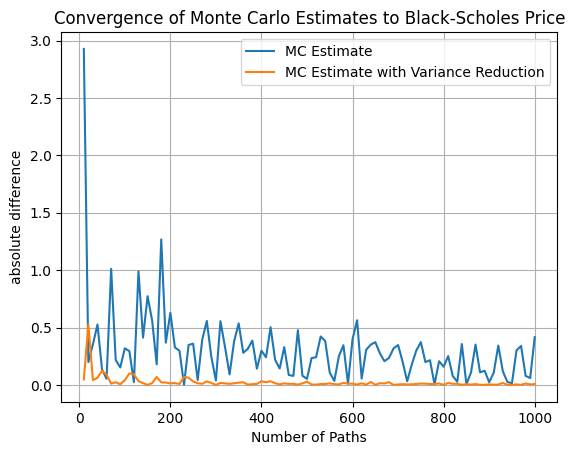

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random_number_gen
gen=random_number_gen.RandomNumberGen()
def black_scholes_call(S, K, T, r, sigma):
    """Calculate the Black-Scholes price of a European call option."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def monte_carlo_call(S, K, T, r, sigma, paths):
    """Monte Carlo simulation for the European call option price."""
    dt = T
    # Simulating the end stock price
    ST = S * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * norm.ppf(np.array(gen.generate_matrix(paths,4,LHS=False)) ) )
    # Calculating the payoff
    payoffs = np.maximum(ST - K, 0)
    # Discounting the payoff back to present value
    call_price_mc = np.exp(-r * T) * np.mean(payoffs)
    return call_price_mc
def monte_carlo_call_antithetic(S, K, T, r, sigma, paths):
    """Monte Carlo simulation for the European call option price."""
    dt = T
    # Simulating the end stock price
    sample=norm.ppf(np.array(gen.generate_matrix(paths//2,4,LHS=True)) )
    #np.random.standard_normal(paths//2)
    sample=np.concatenate([sample,-sample])
    ST = S * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * sample)
    # Calculating the payoff
    payoffs = np.maximum(ST - K, 0)
    # Discounting the payoff back to present value
    call_price_mc = np.exp(-r * T) * np.mean(payoffs)
    
    return call_price_mc

def plot_convergence(S, K, T, r, sigma, max_paths, step,plot=False):
    """Plot the convergence of the Monte Carlo simulation to the Black-Scholes price."""
    bs_price = black_scholes_call(S, K, T, r, sigma)
    paths_range = np.arange(step, max_paths + step, step)
    mc_prices = []

    for num_paths in paths_range:
        mc_price = monte_carlo_call(S, K, T, r, sigma, num_paths)
        mc_prices.append(mc_price)

    diff=np.abs(mc_prices-bs_price*np.ones(len(mc_prices)))
    if plot:
        plt.plot(paths_range, diff, label='MC Estimate')
    

def plot_convergence_antithetic(S, K, T, r, sigma, max_paths, step,plot=False):
    """Plot the convergence of the Monte Carlo simulation to the Black-Scholes price."""
    bs_price = black_scholes_call(S, K, T, r, sigma)
    paths_range = np.arange(step, max_paths + step, step)
    mc_prices = []

    for num_paths in paths_range:
        mc_price = monte_carlo_call_antithetic(S, K, T, r, sigma, num_paths)
        mc_prices.append(mc_price)

    diff=np.abs(mc_prices-bs_price*np.ones(len(mc_prices)))
    if plot:
        plt.plot(paths_range, diff, label='MC Estimate with Variance Reduction')
    # plt.plot(paths_range, diff, label='MC Estimate Antithetic')

        plt.xlabel('Number of Paths')
        plt.ylabel('absolute difference')
        plt.title('Convergence of Monte Carlo Estimates to Black-Scholes Price')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example parameters
S = 100  # Stock price
K = 100  # Strike price
T = 1    # Time to expiration in years
r = 0.05 # Risk-free rate
sigma = 0.2  # Volatility

# Uncomment below line to execute the plotting function
# %timeit plot_convergence(S, K, T, r, sigma, 100000, 100)
# %timeit plot_convergence_antithetic(S, K, T, r, sigma, 100000, 100)
plot_convergence(S, K, T, r, sigma, 1000, 10,plot=True)
plot_convergence_antithetic(S, K, T, r, sigma, 1000, 10,plot=True)

####Model implementation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy
import math
import random_number_gen
import scipy.optimize as optimize
gen=random_number_gen.RandomNumberGen()
from scipy.special import gamma,gammaincc,gammainc,gammaincinv,gammainccinv

C:\Users\Bram\AppData\Local\Temp\ipykernel_24488\2735828433.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample])


(100, 1)
(100, 1)
(100, 1)
[[184.16700404]
 [528.97959888]
 [260.8815514 ]
 [169.8010288 ]
 [377.18082977]
 [133.28482339]
 [306.22586877]
 [226.3380587 ]
 [336.62256566]
 [160.80670347]
 [191.35081226]
 [272.70057029]
 [263.88532435]
 [241.1600358 ]
 [127.80391991]
 [363.62680949]
 [218.35344879]
 [289.36438306]
 [323.25375141]
 [313.95567414]
 [620.14324555]
 [291.57171585]
 [256.02387253]
 [ 94.53566131]
 [203.44549109]
 [386.80031382]
 [438.3575726 ]
 [611.01812834]
 [185.97777529]
 [366.83599279]
 [489.28529925]
 [112.53078162]
 [158.88267925]
 [369.30789347]
 [222.22468895]
 [125.79708755]
 [300.35056662]
 [198.33887521]
 [202.33199111]
 [166.55573209]
 [141.28008735]
 [239.74716335]
 [ 97.43254069]
 [155.96949126]
 [326.89937104]
 [286.74345907]
 [248.42217   ]
 [355.85600398]
 [229.96417224]
 [209.58796054]
 [344.95772395]
 [114.36447601]
 [231.89249803]
 [356.27861074]
 [160.39117015]
 [453.88869568]
 [197.55507556]
 [267.28370382]
 [179.7160405 ]
 [338.13628888]
 [306.1923185

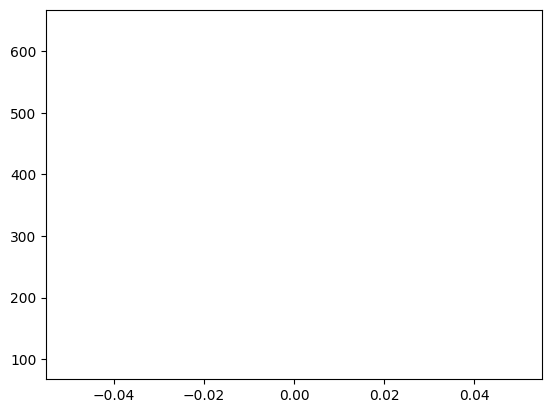

In [ ]:
class Merton():
    def __init__(self,mu,sigma,lambda_,muJ,sigmaJ):
        self.mu=mu
        self.sigma=sigma
        self.lambda_=lambda_
        self.muJ=muJ
        self.sigma_J=sigmaJ
    def simulate_end(self,paths,T,S0=100):
        S=S0*np.exp((self.mu-self.sigma**2/2)*T )
        poisson_sample=gen.generate_poisson(paths,1,self.lambda_*T)
        normal_sample=gen.generate_normal(paths,1)
        max_poisson=np.max(poisson_sample)
        jump_sample=gen.generate_normal(paths,max_poisson,self.muJ,self.sigma_J)
        #%timeit np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample])
        out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample])
        #%timeit np.sum(np.where(out==1,jump_sample,np.zeros((n,int(max_poisson)))),axis=1) ##matrix of 1s and 0s where the sum of each row is equal to the poisson var
        jump_vect=np.sum(np.where(out==1,jump_sample,np.zeros((paths,int(max_poisson)))),axis=1)[:,np.newaxis]
        print((self.sigma*math.sqrt(T)*normal_sample).shape)
        S=S*np.exp(self.sigma*math.sqrt(T)*normal_sample)*np.exp(jump_vect)
        print(jump_vect.shape)
        print(S.shape)
        return S
    def simulate_paths(self,paths,T,N,S0=100):
        dt=T/N
        S=S0*np.ones((paths,N))
        const=np.exp((self.mu-self.sigma**2/2)*dt )
        poisson_sample=gen.generate_poisson(paths,N,self.lambda_*dt)
        normal_sample=gen.generate_normal(paths,N)
        
        for l in range(1,N):
            max_poisson=np.max(poisson_sample[:,l])
            jump_sample=gen.generate_normal(paths,max_poisson,self.muJ,self.sigma_J)
            out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample[:,l]])
            
            S[:,l]=S[:,l-1]*const*np.exp(self.sigma*math.sqrt(T)*normal_sample[:,l])*np.exp(np.sum(np.where(out==1,jump_sample,np.zeros((paths,int(max_poisson)))),axis=1))
        
        return S
    def update_params(self,params):
        self.mu,self.sigma,self.lambda_,self.muJ,self.sigma_J=params
    def update_time(self,T):
        pass

X=Merton(0.05,0.1,0.01,-0.05,0.1)
S=X.simulate_end(100,20)
print(S)
plt.plot(S.transpose())
plt.show()


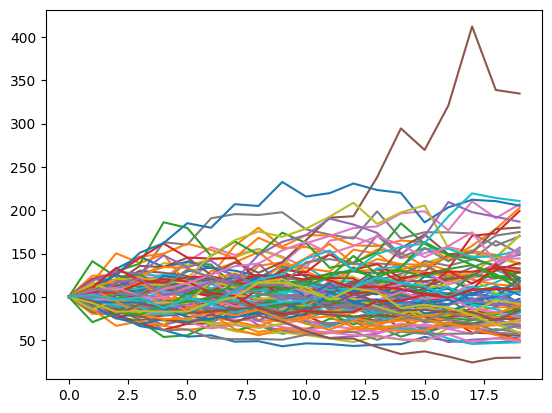

In [ ]:
class Kou():
    def __init__(self,mu,sigma,lambda_,p,eta1,eta2):
        self.mu=mu
        self.sigma=sigma
        self.lambda_=lambda_
        self.p=p
        self.eta1=eta1
        self.eta2=eta2
    def simulate_end(self,paths,T,S0=100):
        S=S0*np.exp((self.mu-self.sigma**2/2)*T )
        poisson_sample=gen.generate_poisson(paths,1,self.lambda_*T)
        normal_sample=gen.generate_normal(paths,1)
        max_poisson=np.max(poisson_sample)
        jump_sample=gen.generate_double_exponential(paths,max_poisson,self.p,self.eta1,self.eta2)
        out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample])
        jump_vect=np.sum(np.where(out==1,jump_sample,np.zeros((paths,int(max_poisson)))),axis=1)[:,np.newaxis]
        S=S*np.exp(self.sigma*math.sqrt(T)*normal_sample)*np.exp(jump_vect)
        return S
    def update_time(self,t):
        pass
    def update_params(self,params):
        self.mu,self.sigma,self.lambda_,self.p,self.eta1,self.eta2=params
    
    def simulate_paths(self,paths,T,N,S0=100):
        dt=T/N
        S=S0*np.ones((paths,N))
        const=np.exp((self.mu-self.sigma**2/2)*dt )
        poisson_sample=gen.generate_poisson(paths,N,self.lambda_*dt)
        normal_sample=gen.generate_normal(paths,N)
        
        for l in np.arange(1,int(N)):
            max_poisson=np.max(poisson_sample[:,l])
            jump_sample=gen.generate_double_exponential(paths,max_poisson,self.p,self.eta1,self.eta2)
            out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample[:,l]])
            
            S[:,l]=S[:,l-1]*np.exp(self.sigma*math.sqrt(T)*normal_sample[:,l])*np.exp(np.sum(np.where(out==1,jump_sample,np.zeros((paths,int(max_poisson)))),axis=1))
        
        return S
    def update_params(self,params):
        self.mu,self.sigma,self.lambda_,self.p,self.eta1,self.eta2=params

X=Kou(0.05,0.1,0.01,0.5,0.1,0.1)
S=X.simulate_paths(100,1,20)
plt.plot(S.transpose())
plt.show()

In [ ]:
class CGMY():
  def __init__(self,C,G,M,Y,eta,mu):
      self.C=C
      self.G=G
      self.M=M
      self.Y=Y
      self.eta=eta
      self.generated=False
      self.mu=mu
  
  def characteristic_function(self,u,t,increment=[0,0,0,0]):

    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
    return np.exp(t*C*gamma(-Y)*((M-1j*u)**Y-M**Y+(G+1j*u)**Y-G**Y))

  def calculate_K(self,increment=[0,0,0,0]):
    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
    
    return -C*gamma(-Y)*(M**Y+G**Y)

  def reg_characteristic_function(self,u,t):
    if u!=0:
      return -(1-np.cos(u*self.D))/(1j*u)*self.characteristic_function(u,t)
    else:
      return 0

  def L_error(self,L,B,b,beta,D,error):

    Bounderror=D*B/(np.pi*beta*b**(1/beta))*gammaincc(1/beta,b*(L/2)**beta)-error

    return L if Bounderror<0 else np.inf ##if bound is met, return L. Else, return infinity for penalty
  def alpha_minimization(self, alpha):
    t, error = self.t, self.error
    return np.real((2 / alpha) * np.log(
      (self.characteristic_function(1j * alpha, t) + self.characteristic_function(-1j * alpha, t)) / (2 * error / 3)))
  def L_value(self,b):
    res=optimize.minimize_scalar(self.L_error,args=(self.B,b,self.beta,self.D,self.error),bracket=[0, 1000], method='bounded',bounds=(0,35))
    return res.x
  def calculate_zeta(self, alpha):
    C, G, M, Y = self.C, self.G, self.M, self.Y
    term1 = -self.t * C * gamma(-Y) * (G ** Y - (G - alpha) ** Y)
    term2 = -self.t * C * gamma(-Y) * (M ** Y - (M + alpha) ** Y)
    term1 = np.clip(term1, a_min=None, a_max=600)#for numerical stability
    term2 = np.clip(term2, a_min=None, a_max=600)#for numerical stability
    return np.exp(np.logaddexp(term1, term2))

  def calculate_h_from_C(self, C):
    X = self.error * 2 * np.pi / (3 * C)
    return -2 * np.pi * self.alpha / (np.log(X / (1 + X)))
  def calculate_f(self,u,increment=[0,0,0,0]):
    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
    part1=(G**2/u**2+1)**(Y/2)*np.cos(Y*np.arctan(u/G))
    part2=(M**2/u**2+1)**(Y/2)*np.cos(Y*np.arctan(u/M))
    return gamma(-Y)*(part1+part2)
  def abs_char(self,u,alpha):
    return np.exp(self.t*self.K+self.t*self.C*np.abs(u)**self.Y*self.calculate_f(u,[0,-alpha,alpha,0]))


  def calculate_bound_A_integrals(self, alpha, u_star):
    """
    Calculates the bound A integrals for a given alpha and u_star.

    Parameters:
    alpha (float): The alpha value.
    u_star (float): The u_star value.

    Returns:
    float: The calculated bound A value.
    """
    stand_incr = [0, -alpha, alpha, 0]
    ##for calculating positive alpha integrals and zeta
    pos_alpha_K = self.calculate_K(increment=stand_incr)

    pos_alpha_int = scipy.integrate.quad(lambda x: self.abs_char(x,alpha),10e-10,u_star)[0]

    pos_alpha_upp = np.exp(self.t * pos_alpha_K) / (self.beta * self.b ** (1 / self.beta)) * gammaincc(1 / self.beta,
                self.b * u_star ** self.beta)
    
    pos_alpha_all_int = self.calculate_zeta(alpha) * (pos_alpha_int + pos_alpha_upp)
    ##for calculating negative alpha integrals and zeta
    neg_incr = [0, alpha, -alpha, 0]
    
    neg_alpha_K = self.calculate_K(increment=neg_incr)

    neg_alpha_int = scipy.integrate.quad(lambda x: self.abs_char(x,-alpha),10e-10,u_star)[0]
    
    neg_alpha_upp = np.exp(self.t * neg_alpha_K) / (self.beta * self.b ** (1 / self.beta)) * gammaincc(1 / self.beta,
                   self.b * u_star ** self.beta)

    neg_alpha_all_int = self.calculate_zeta(-alpha) * (neg_alpha_int + neg_alpha_upp)

    
    all_int = pos_alpha_all_int + neg_alpha_all_int+10e-9 #for numerical stability

    #for numerical stability
    part1 = np.exp(np.clip(((-self.D * self.alpha / 2+2*(self.D * self.alpha))), a_min=None, a_max=600))

    part2 = 2 * np.exp(np.clip((-self.D * self.alpha / 2+ self.D * self.alpha), a_min=None, a_max=600))
    part3 = np.exp(-self.D * self.alpha / 2)
    
    A = 1 / self.alpha * (part1+part2+part3) + all_int
    return A 

  def generate_cdf(self):
    """
    Generate the cumulative distribution function (CDF) for the Jump Diffusion Model.

    Parameters:
    

    Returns:
    - x_range (numpy.ndarray): An array of x values.
    - M (numpy.ndarray): An array of real values representing the CDF.

    """
    t=self.t
    ##Regularization error
    alpha_bounds = (0, np.min([self.G, self.M]))
    optimization = optimize.minimize_scalar(self.alpha_minimization, 1, bounds=alpha_bounds)
    self.alpha = optimization.x
    print("Fourier Inversion Parameters:###########")
    print("alpha:", self.alpha)
    self.D = optimization.fun
    print("D:", self.D)
    ##Truncating error
    self.K = self.calculate_K()
    K=self.K
    self.beta = self.Y
    self.B = np.exp(t * K)

    if self.Y > 1:
      u_star = max(self.G, self.M) * max(np.tan(np.pi / (2 * self.Y)), -1 / np.tan(self.Y * np.pi / 2))

      self.b = -t * self.C * self.calculate_f(np.ceil(u_star))
      C = self.calculate_bound_A_integrals(self.alpha, u_star)

      h=self.calculate_h_from_C(C)
      L_opt = max(self.L_value(self.b), np.ceil(u_star))
     
    elif self.Y > 0:
      b = -t * 2 * self.C * gamma(-self.Y) * np.cos(np.pi * self.Y / 2)
      L_opt = self.L_value(b)
      A = (2 * np.exp(-self.D * self.alpha / 2) * (np.exp(self.D * self.alpha) + 1) ** 2 * self.B * gamma(
        1 / self.beta)) / (self.alpha * self.beta * b ** (1 / self.beta))

      h=self.calculate_h_from_C(A)
    print("L_opt:", L_opt)
    print("h:", h)

    N = np.ceil(L_opt / h)
    print("N:", N)
    eta = self.D / N
    print(  "eta:", eta)





    ###Vectorized Operations for faster computation
 
    u_domain = np.arange(-N/2*h, (N/2)*h, h)
    x_range = np.arange(-N/2*eta, (N/2)*eta, eta)

    const = 1/(2*np.pi) * h

    
    reg_char_func_vect = np.vectorize(lambda u: self.reg_characteristic_function(u, t))

    # Computing the characteristic values for each u in u_domain
    characteristic_values = reg_char_func_vect(u_domain)

    # Pre-compute the exponential part using broadcasting
    # np.outer effectively creates a matrix where each row corresponds to an element in u_domain and each column to an element in x_range
    exp_matrix = np.exp(-1j * np.outer(u_domain, x_range))

    # Element-wise multiplication of exp_matrix with characteristic_values (reshaped for broadcasting)
    vect = exp_matrix * characteristic_values[:, np.newaxis]

    # Compute results by integrating (summing) over the u_domain for each x_range index
    res = const * vect
    real_res = np.sum(res, axis=0)  # Summing along the 'u_domain' axis

    M2 = real_res  # M contains the real parts of the computed values for each x_range index
    
    M2+=np.ones(len(M2))*0.5
    self.generated=True
    self.CumDensity=(x_range,np.real(M2))
    return x_range,np.real(M2)
  
    
  def generate_inverse_transform_sample(self,n,rows):
    if not self.generated:
      self.generate_cdf()
    return gen.inverse_transform(gen.generate_matrix(n,rows),self.CumDensity[1],self.CumDensity[0])
  def generate_sample(self,n,rows,t,error):
    self.t=t
    self.error=error
    if self.Y>0:
      out=self.generate_inverse_transform_sample(n,rows)
    else:
      out=gen.generate_CGMY_Ylessthan1(n,rows,self.C,self.G,self.M,self.Y)
    return out
  def update_params(self,params):
    self.C,self.G,self.M,self.Y,self.eta=params
    self.generated=False
  def update_time(self,t):
    self.t=t
    self.generated=False
  def calculate_omega(self):
    omega=-np.log(self.characteristic_function(-1j,self.t))/self.t
    return omega
  def simulate_end(self,paths,T,s0,error=10e-9):
    S=s0
    cgmy_sample=np.real(self.generate_sample(paths,1,T,error))
    omega=self.calculate_omega()
   
    S=np.exp((self.mu+omega-self.eta**2/2))*S
    normal_sample=gen.generate_normal(paths,1)
 
    S=S*np.exp(cgmy_sample)
   
    S=S*np.exp(self.eta*np.sqrt(T)*normal_sample)
    
    return np.real(S)
  def simulate_paths(self,paths,N,T,s0,error):
    dt=T/N
    S=s0*np.ones((paths,N))
    cgmy_sample=self.generate_sample(paths,N,dt,error)
    omega=self.calculate_omega()
    S=np.exp((self.mu+omega-self.eta**2/2))*S
    normal_sample=gen.generate_normal(paths,N)
    for l in range(1,N):
        S[:,l]=S[:,l-1]*np.exp(cgmy_sample[:,l]+self.eta*np.sqrt(dt)*normal_sample[:,l])
    return np.real(S)

  
X=CGMY(2,12,12,-0.6,0.04,0.05)




###Downloading the Data

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import datetime
from scipy.special import gamma,gammaincc,gammainc,gammaincinv,gammainccinv

In [ ]:
__TICKERS_TO_CHECK=["TSLA","AAPL","MSFT"]

In [ ]:
class Download_data():
    def __init__(self,tickers):
        self.tickers=tickers
        self.columns_to_keep=["contractSymbol",	"strike","volume",	"lastPrice",	"impliedVolatility",	"currency"]
    def download_data(self,ticker,period):
        data=yf.download(ticker,period=period)
        data.log_price=np.diff(np.log(data["Adj Close"]))
        pd.DataFrame(data.log_price).to_csv(f"{ticker}.csv")
        return {datetime.datetime.today().strftime('%Y-%m-%d'):ticker}
    def get_option_chain(self,ticker,nb_strikes,nb_exp):
        YFTICKER=yf.Ticker(ticker)
        option_chain=YFTICKER.option_chain()
        current_price=YFTICKER.history(period="1d")["Close"][0]
       
        
        exp=list(YFTICKER._expirations.keys())[0:nb_exp]
        
        output=pd.DataFrame()
        for l in exp:
            
            temp_option_chain=YFTICKER.option_chain(l)
            all_options=temp_option_chain.calls._append(temp_option_chain.puts)
            delta=np.sort(np.abs(np.diff(all_options["strike"])))[0]
            
            all_options=all_options[all_options["strike"].between(current_price-delta*nb_strikes,current_price+delta*nb_strikes)]
            all_options=all_options[self.columns_to_keep]
            output=pd.concat([output,all_options],ignore_index=True)
        output.to_csv(f"{ticker}_option_chain.csv")
        return {datetime.datetime.today().strftime('%Y-%m-%d'):ticker}
    def get_data(self):
        output={}
        for l in self.tickers:
            try:
                pd.read_csv(f"{l}.csv")
                import os
                import datetime

                

                # Get the modification time of the file
                file_time = os.path.getmtime(f"{l}.csv")

                # Convert the modification time to a datetime object
                file_date = datetime.datetime.fromtimestamp(file_time).date()

                # Get today's date
                today = datetime.date.today()

                # Compare the file date with today's date
                if file_date == today:
                    print("The time from the asset return file matches today's date.")
                else:
                    print("The time from the asset return file does not match today's date.")
                    output.update(self.download_data(l,"1y"))
            except:
                output.update(self.download_data(l,"1y"))
            try:
                pd.read_csv(f"{l}_option_chain.csv")
                import os
                import datetime

                

                # Get the modification time of the file
                file_time = os.path.getmtime(f"{l}_option_chain.csv")

                # Convert the modification time to a datetime object
                file_date = datetime.datetime.fromtimestamp(file_time).date()

                # Get today's date
                today = datetime.date.today()

                # Compare the file date with today's date
                if file_date == today:
                    print("The time from the option chain file matches today's date.")
                else:
                    print("The time from the option chain file does not match today's date.")
                    output.update(self.get_option_chain(l,5,5))
            except:
                output.update(self.get_option_chain(l,5,5))
        
        return output

x=Download_data(__TICKERS_TO_CHECK)
x.get_data()

The time from the asset return file matches today's date.
The time from the option chain file matches today's date.
The time from the asset return file matches today's date.
The time from the option chain file matches today's date.
The time from the asset return file matches today's date.
The time from the option chain file matches today's date.


{}

###Calculating Option Prices:

In [105]:
class Option_Price_Calculator():
    def __init__(self):
        self.discount_rate=0.05
        pass
    def transform_into_df(self,option_names):
        ext=option_names.str.extract(r'(\D{4})(\d{6})(\D)(\d+)', expand=True)
        ext.columns=["Ticker","Date","Type","Strike"]
        
        
        ext.Date=pd.to_datetime(ext.Date,format="%y%m%d")
        ext.Strike=ext.Strike.astype(float)/1000
        out=pd.concat([option_names,ext],axis=1)
        out.columns=["Option","Ticker","Date","Type","Strike"]
        return out
    def price_options(self,option_chain,s0,nb_simulations,model):
        X=self.transform_into_df(option_chain["contractSymbol"])
        all_sims=pd.DataFrame()
        
        X["Sim_price"]=np.nan
        for l in X.Date.unique():
            
            time_to_exp=((l-pd.Timestamp.today()).days+1)/365
            model.update_time(time_to_exp)
            
            sim=np.real(model.simulate_end(nb_simulations,time_to_exp,s0))
            
            sim=pd.DataFrame(sim,columns=[datetime.datetime.strftime(l,"%Y-%m-%d")])
            all_sims=pd.concat([all_sims,pd.DataFrame(sim)],axis=1)
        
        for i,j in enumerate(X.Date):
            Delay=(j-pd.Timestamp.today()).days/365
            index=datetime.datetime.strftime(j,"%Y-%m-%d")
            
            exp_S=s0*np.exp(Delay*self.discount_rate)
            
            sim_prices=all_sims[index]
            if X.Type[i]=="C":
                Exp_price=np.maximum(sim_prices-X.Strike[i],0)
                
            else:
                Exp_price=np.maximum(X.Strike[i]-sim_prices,0)
            
            

            b_hat=np.cov(sim_prices,Exp_price)[0,1]/np.var(sim_prices)
            
            
            Control_Var_adj=Exp_price-b_hat*(all_sims[index]-exp_S)
            
            X.loc[i,"Sim_price"]=max(np.exp(-Delay*self.discount_rate)*np.mean(Control_Var_adj),0)
        return X
p=Option_Price_Calculator()
Price=p.price_options(pd.read_csv("AAPL_option_chain.csv"),180,1000,CGMY(5,12,12,-0.6,0.04,0.05))


0     172.5
1     175.0
2     177.5
3     180.0
4     182.5
      ...  
81    185.0
82    190.0
83    195.0
84    200.0
85    205.0
Name: Strike, Length: 86, dtype: float64
                 Option Ticker       Date Type  Strike  Sim_price
0   AAPL240517C00172500   AAPL 2024-05-17    C   172.5  10.173839
1   AAPL240517C00175000   AAPL 2024-05-17    C   175.0   8.184123
2   AAPL240517C00177500   AAPL 2024-05-17    C   177.5   6.292081
3   AAPL240517C00180000   AAPL 2024-05-17    C   180.0   4.527568
4   AAPL240517C00182500   AAPL 2024-05-17    C   182.5   2.922242
..                  ...    ...        ...  ...     ...        ...
81  AAPL240614P00185000   AAPL 2024-06-14    P   185.0   6.177591
82  AAPL240614P00190000   AAPL 2024-06-14    P   190.0   9.537171
83  AAPL240614P00195000   AAPL 2024-06-14    P   195.0  13.897021
84  AAPL240614P00200000   AAPL 2024-06-14    P   200.0  18.619480
85  AAPL240614P00205000   AAPL 2024-06-14    P   205.0  23.525959

[86 rows x 6 columns]
